In [1]:
from google.colab import drive
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda, BatchNormalization, Dropout, GlobalAveragePooling2D, Concatenate, Activation, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# Mount Google Drive
drive.mount('/content/drive')

# Load the labels
labels_path = '/content/drive/MyDrive/Contrastive Learning/contrastive_learning_labels.csv'
labels_df = pd.read_csv(labels_path)

# Directory path where images are stored
image_dir = '/content/drive/MyDrive/Contrastive Learning/contrastive_learning_images'

# Check if the image directory exists
if not os.path.exists(image_dir):
    print("Image directory not found!")
else:
    print("Images are ready for training.")

Mounted at /content/drive
Images are ready for training.


# Modelling -> Only using pixel ratio

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu', dropout_rate=0.4):
    res = Conv2D(filters, kernel_size, strides=stride, padding='same', activation=activation)(x)
    res = BatchNormalization()(res)
    res = Dropout(dropout_rate)(res)

    res = Conv2D(filters, kernel_size, strides=1, padding='same', activation=None)(res)
    res = BatchNormalization()(res)

    if x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', activation=None)(x)

    res = Add()([x, res])
    res = Activation(activation)(res)
    return res

def make_embedding_model(input_shape=(224, 224, 3), scalar_shape=(1,), embedding_dim=256, dropout_rate=0.4):
    inp = Input(shape=input_shape, name='input_image')

    c1 = Conv2D(64, (7, 7), strides=2, activation='relu', padding='same', name='conv_layer_1')(inp)
    c1 = BatchNormalization()(c1)
    m1 = MaxPooling2D((3, 3), strides=2, padding='same', name='pool_layer_1')(c1)

    r1 = residual_block(m1, 128, dropout_rate=dropout_rate)
    r2 = residual_block(r1, 256, dropout_rate=dropout_rate)
    r3 = residual_block(r2, 512, dropout_rate=dropout_rate)  # Adding an additional residual block
    r4 = residual_block(r3, 512, dropout_rate=dropout_rate)  # Adding another additional residual block

    f1 = GlobalAveragePooling2D(name='global_avg_pool')(r4)  # Updated to use the final residual block

    scalar_input = Input(shape=scalar_shape, name='input_scalar')
    scalar_dense = Dense(128, activation='relu')(scalar_input)  # Increased the number of units
    scalar_dense = BatchNormalization()(scalar_dense)
    scalar_dense = Dropout(dropout_rate)(scalar_dense)

    combined = Concatenate(name='concat_image_scalar')([f1, scalar_dense])

    dense_1 = Dense(1024, activation='relu', name='dense_layer_1')(combined)  # Increased the number of units
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(dropout_rate)(dense_1)

    dense_2 = Dense(512, activation='relu', name='dense_layer_2')(dense_1)  # Added another dense layer
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(dropout_rate)(dense_2)

    embedding = Dense(embedding_dim, name='embedding_layer')(dense_2)
    embedding = BatchNormalization(name='embedding_batch_norm')(embedding)

    return Model(inputs=[inp, scalar_input], outputs=embedding, name='embedding_model')

class RandomSaturation(tf.keras.layers.Layer):
    def __init__(self, factor=0.2, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, images, training=None):
        if training:
            return tf.image.random_saturation(images, 1 - self.factor, 1 + self.factor)
        return images

class RandomHue(tf.keras.layers.Layer):
    def __init__(self, factor=0.2, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, images, training=None):
        if training:
            return tf.image.random_hue(images, self.factor)
        return images

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2),
    RandomSaturation(factor=0.2),  # Custom saturation layer
    RandomHue(factor=0.2),         # Custom hue layer
    # Custom layer to add Gaussian noise or Random Cutout if desired
])

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    max_lr = 1e-3
    min_lr = 1e-6
    total_epochs = 500
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / total_epochs))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Adjust the data generator to include augmentation
def data_generator(save_dir, batch_size=32, is_validation=False, augment=False):
    pairs_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('pairs_batch_') and f.endswith('.npy')])
    scalar_features_1_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_1_batch_') and f.endswith('.npy')])
    scalar_features_2_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_2_batch_') and f.endswith('.npy')])
    labels_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('labels_batch_') and f.endswith('.npy')])

    # Combine the batches to shuffle them together
    combined_batches = list(zip(pairs_batches, scalar_features_1_batches, scalar_features_2_batches, labels_batches))

    # Shuffle the combined batches
    np.random.shuffle(combined_batches)

    # Unzip back to individual lists
    pairs_batches, scalar_features_1_batches, scalar_features_2_batches, labels_batches = zip(*combined_batches)

    # Determine the split point for validation
    validation_size = int(0.2 * len(pairs_batches))

    if is_validation:
        # Use a random 20% for validation
        pairs_batches = pairs_batches[:validation_size]
        scalar_features_1_batches = scalar_features_1_batches[:validation_size]
        scalar_features_2_batches = scalar_features_2_batches[:validation_size]
        labels_batches = labels_batches[:validation_size]
    else:
        # Use the remaining 80% for training
        pairs_batches = pairs_batches[validation_size:]
        scalar_features_1_batches = scalar_features_1_batches[validation_size:]
        scalar_features_2_batches = scalar_features_2_batches[validation_size:]
        labels_batches = labels_batches[validation_size:]

    while True:
        for pair_file, sf1_file, sf2_file, label_file in zip(pairs_batches, scalar_features_1_batches, scalar_features_2_batches, labels_batches):
            pairs = np.load(os.path.join(save_dir, pair_file))
            scalar_features_1 = np.load(os.path.join(save_dir, sf1_file))[:, 1:2]  # Only take the pixel_to_mm_ratio
            scalar_features_2 = np.load(os.path.join(save_dir, sf2_file))[:, 1:2]  # Only take the pixel_to_mm_ratio
            labels = np.load(os.path.join(save_dir, label_file))

            num_batches = len(pairs) // batch_size
            for i in range(num_batches):
                batch_pairs = pairs[i * batch_size:(i + 1) * batch_size]
                batch_sf1 = scalar_features_1[i * batch_size:(i + 1) * batch_size]
                batch_sf2 = scalar_features_2[i * batch_size:(i + 1) * batch_size]
                batch_labels = labels[i * batch_size:(i + 1) * batch_size]

                if augment and not is_validation:
                    batch_pairs[:, 0] = data_augmentation(batch_pairs[:, 0])
                    batch_pairs[:, 1] = data_augmentation(batch_pairs[:, 1])

                yield (
                    (
                        tf.convert_to_tensor(batch_pairs[:, 0], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf1, dtype=tf.float32),
                        tf.convert_to_tensor(batch_pairs[:, 1], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf2, dtype=tf.float32)
                    ),
                    tf.convert_to_tensor(batch_labels, dtype=tf.float32)
                )

# Define the input shapes
image_shape = (224, 224, 3)
scalar_shape = (1,)

# Load the embedding model with scalar features included
base_network = make_embedding_model(input_shape=image_shape, scalar_shape=scalar_shape, embedding_dim=128)

# Input tensors for the two images and scalar features
input_a = Input(shape=image_shape, name='input_img_a')
input_b = Input(shape=image_shape, name='input_img_b')

scalar_input_a = Input(shape=scalar_shape, name='input_scalar_a')
scalar_input_b = Input(shape=scalar_shape, name='input_scalar_b')

# Generate embeddings for both inputs (image + scalar features)
embedding_a = base_network([input_a, scalar_input_a])
embedding_b = base_network([input_b, scalar_input_b])

# Calculate the distance between the embeddings
distance_layer = Lambda(lambda x: tf.math.square(x[0] - x[1]), name='distance_layer')
distance_output = distance_layer([embedding_a, embedding_b])

# Add classification layer
classifier = Dense(1, activation='sigmoid', name='classifier')(distance_output)

# Define the contrastive model with scalar inputs
model = Model(inputs=[input_a, scalar_input_a, input_b, scalar_input_b], outputs=[classifier, distance_output])

# Define the contrastive loss function
class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        label = tf.cast(y_true, tf.float32)
        neg_dist = tf.maximum(self.margin - y_pred, 0)
        return tf.reduce_mean(label * y_pred + (1.0 - label) * neg_dist, axis=-1)

# Instantiate loss functions
loss_contrastive = ContrastiveLoss(margin=1.0)
loss_classifier = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)

# Compile the model
model.compile(
    loss=[loss_classifier, loss_contrastive],
    optimizer=optimizer,
    loss_weights=[1.0, 1.0],
    metrics=[['accuracy'], []]  # accuracy for classifier, no metrics for the contrastive loss
)

# Training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=False, augment=True),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),            # Scalar features A (corrected to shape (None, 1))
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)             # Scalar features B (corrected to shape (None, 1))
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=True),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),            # Scalar features A (corrected to shape (None, 1))
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)             # Scalar features B (corrected to shape (None, 1))
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

# Training the model with a learning rate scheduler
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=500,
    steps_per_epoch=100,
    validation_steps=20,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
        lr_schedule
    ]
)

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - classifier_accuracy: 0.5071 - loss: 1.4674
Epoch 1: val_loss improved from inf to 0.68624, saving model to /content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 501ms/step - classifier_accuracy: 0.5073 - loss: 1.4654 - val_classifier_accuracy: 0.5328 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - classifier_accuracy: 0.5359 - loss: 0.9459
Epoch 2: val_loss did not improve from 0.68624
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 477ms/step - classifier_accuracy: 0.5359 - loss: 0.9453 - val_classifier_accuracy: 0.5078 - val_loss: 0.7045 - learning_rate: 9.9999e-04
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - classifier_accuracy: 0.5330 - loss: 0.8062
Epoch 3: val_loss did not improve from 0.68624
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - classifier_accuracy: 0.5329 - loss: 0.8059 - val_classifier_accuracy: 0.5766 - val_loss

KeyboardInterrupt: 

In [ ]:
base_network.save('/content/drive/MyDrive/Contrastive Learning/base_embedding_model.keras')

# Triplet Loss Model

In [ ]:
labels_df = labels_df[labels_df['bags_used']<5]

In [ ]:
def load_image(pothole_id, directory=image_dir, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

# Standardize the scalar features
def standardize_features(labels_df):
    scaler = StandardScaler()
    labels_df[['mm_to_pixel_ratio']] = scaler.fit_transform(
        labels_df[['mm_to_pixel_ratio']]
    )
    return labels_df, scaler

# Create and save triplets function
def create_and_save_triplets(labels_df, batch_size=1000, triplets_per_image=3, save_dir='/content/drive/MyDrive/triplets_batches'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Ensure the directory exists

    batch_count = 0

    grouped = labels_df.groupby('class')
    total_groups = len(grouped)

    progress_interval = max(1, total_groups // 10)

    def save_batch(batch_id, anchors, positives, negatives, scalar_features_anchor, scalar_features_pos_neg):
        np.save(os.path.join(save_dir, f'anchors_batch_{batch_id}.npy'), anchors)
        np.save(os.path.join(save_dir, f'positives_batch_{batch_id}.npy'), positives)
        np.save(os.path.join(save_dir, f'negatives_batch_{batch_id}.npy'), negatives)
        np.save(os.path.join(save_dir, f'scalar_features_anchor_batch_{batch_id}.npy'), scalar_features_anchor)
        np.save(os.path.join(save_dir, f'scalar_features_pos_neg_batch_{batch_id}.npy'), scalar_features_pos_neg)

    anchors = []
    positives = []
    negatives = []
    scalar_features_anchor = []
    scalar_features_pos_neg = []

    for idx, (class_name, group) in enumerate(grouped):
        if idx % progress_interval == 0:
            print(f"Progress: {min(100, idx / total_groups * 100):.1f}% (Processing triplets)")

        pothole_ids = group['pothole_id'].values
        if len(pothole_ids) > 1:
            for i in range(len(pothole_ids)):
                anchor_img = load_image(pothole_ids[i])

                for j in range(triplets_per_image):
                    # Positive example
                    pos_id = np.random.choice(pothole_ids)
                    while pos_id == pothole_ids[i]:
                        pos_id = np.random.choice(pothole_ids)
                    pos_img = load_image(pos_id)

                    # Negative example
                    class_names = labels_df['class'].unique()
                    neg_class = np.random.choice([cls for cls in class_names if cls != class_name])
                    neg_id = labels_df[labels_df['class'] == neg_class].sample(1)['pothole_id'].values[0]
                    neg_img = load_image(neg_id)

                    # Collecting images
                    anchors.append(anchor_img)
                    positives.append(pos_img)
                    negatives.append(neg_img)

                    # Collecting scalar features (using only mm_to_pixel_ratio)
                    scalar_anchor = group[group['pothole_id'] == pothole_ids[i]][['mm_to_pixel_ratio']].values[0]
                    scalar_pos = group[group['pothole_id'] == pos_id][['mm_to_pixel_ratio']].values[0]
                    scalar_neg = labels_df[labels_df['pothole_id'] == neg_id][['mm_to_pixel_ratio']].values[0]

                    scalar_features_anchor.append(scalar_anchor)
                    scalar_features_pos_neg.append((scalar_pos, scalar_neg))

                    if len(anchors) >= batch_size:
                        save_batch(batch_count, anchors, positives, negatives, scalar_features_anchor, scalar_features_pos_neg)
                        anchors, positives, negatives, scalar_features_anchor, scalar_features_pos_neg = [], [], [], [], []
                        batch_count += 1

    if len(anchors) > 0:
        save_batch(batch_count, anchors, positives, negatives, scalar_features_anchor, scalar_features_pos_neg)

    print(f"Progress: 100% (Triplet creation completed in {batch_count + 1} batches)")

# Example usage
labels_df, scaler = standardize_features(labels_df)
create_and_save_triplets(labels_df, batch_size=1000, triplets_per_image=3)

NameError: name 'standardize_features' is not defined

Anchors shape: (1000, 224, 224, 3)
Positives shape: (1000, 224, 224, 3)
Negatives shape: (1000, 224, 224, 3)
Scalar anchors shape: (1000, 1)
Scalar pos_neg shape: (1000, 2, 1)

First triplet (image shapes and scalar features):
Anchor image shape: (224, 224, 3)
Positive image shape: (224, 224, 3)
Negative image shape: (224, 224, 3)
Anchor scalar: [-0.78774683]
Positive scalar: [0.1131953]
Negative scalar: [2.1089071]


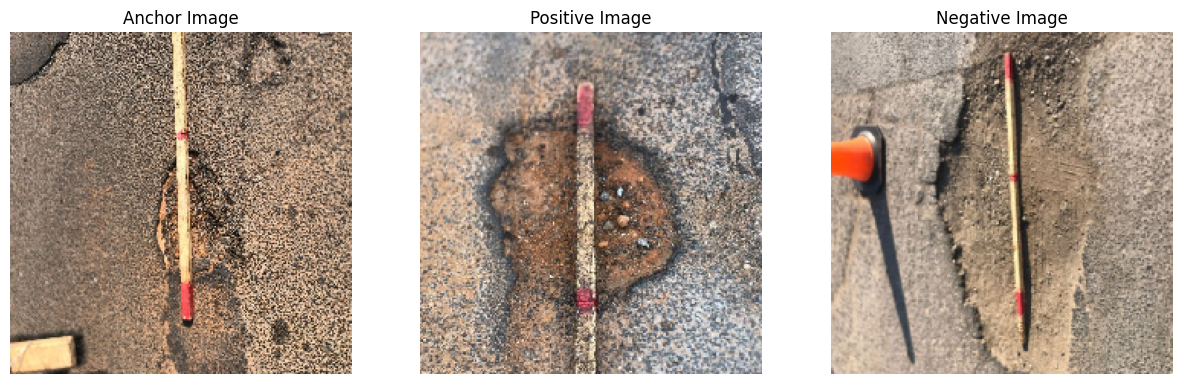

In [ ]:
def verify_saved_triplets(save_dir, batch_id=0):
    anchor_file = os.path.join(save_dir, f'anchors_batch_{batch_id}.npy')
    positive_file = os.path.join(save_dir, f'positives_batch_{batch_id}.npy')
    negative_file = os.path.join(save_dir, f'negatives_batch_{batch_id}.npy')
    scalar_anchor_file = os.path.join(save_dir, f'scalar_features_anchor_batch_{batch_id}.npy')
    scalar_pos_neg_file = os.path.join(save_dir, f'scalar_features_pos_neg_batch_{batch_id}.npy')

    # Load the saved batches
    anchors = np.load(anchor_file)
    positives = np.load(positive_file)
    negatives = np.load(negative_file)
    scalar_anchors = np.load(scalar_anchor_file)
    scalar_pos_neg = np.load(scalar_pos_neg_file)

    # Print shapes to verify
    print(f"Anchors shape: {anchors.shape}")
    print(f"Positives shape: {positives.shape}")
    print(f"Negatives shape: {negatives.shape}")
    print(f"Scalar anchors shape: {scalar_anchors.shape}")
    print(f"Scalar pos_neg shape: {scalar_pos_neg.shape}")

    # Optionally, you can inspect the first triplet
    print("\nFirst triplet (image shapes and scalar features):")
    print(f"Anchor image shape: {anchors[0].shape}")
    print(f"Positive image shape: {positives[0].shape}")
    print(f"Negative image shape: {negatives[0].shape}")
    print(f"Anchor scalar: {scalar_anchors[0]}")
    print(f"Positive scalar: {scalar_pos_neg[0][0]}")
    print(f"Negative scalar: {scalar_pos_neg[0][1]}")

    # Plot the first triplet to visually verify
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(anchors[0])
    plt.title("Anchor Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(positives[0])
    plt.title("Positive Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(negatives[0])
    plt.title("Negative Image")
    plt.axis('off')

    plt.show()

# Example usage to verify the first batch
verify_saved_triplets('/content/drive/MyDrive/triplets_batches', batch_id=0)

In [ ]:
def load_image(pothole_id, directory=image_dir, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

def standardize_features(labels_df):
    scaler = StandardScaler()
    labels_df[['mm_to_pixel_ratio']] = scaler.fit_transform(
        labels_df[['mm_to_pixel_ratio']]
    )
    return labels_df, scaler

def triplet_generator(labels_df, batch_size=32):
    while True:
        anchors = []
        positives = []
        negatives = []
        scalar_anchor = []
        scalar_pos = []
        scalar_neg = []

        for _ in range(batch_size):
            anchor = labels_df.sample(1).iloc[0]
            positive = labels_df[labels_df['class'] == anchor['class']].sample(1).iloc[0]
            negative = labels_df[labels_df['class'] != anchor['class']].sample(1).iloc[0]

            anchors.append(load_image(anchor['pothole_id']))
            positives.append(load_image(positive['pothole_id']))
            negatives.append(load_image(negative['pothole_id']))

            scalar_anchor.append([anchor['mm_to_pixel_ratio']])
            scalar_pos.append([positive['mm_to_pixel_ratio']])
            scalar_neg.append([negative['mm_to_pixel_ratio']])

        yield (
            {
                'input_anchor_image': np.array(anchors),
                'input_pos_image': np.array(positives),
                'input_neg_image': np.array(negatives),
                'input_scalar_anchor': np.array(scalar_anchor),
                'input_scalar_pos': np.array(scalar_pos),
                'input_scalar_neg': np.array(scalar_neg)
            },
            np.zeros((batch_size, 3))  # Dummy target for the triplet loss
        )

def triplet_dataset(labels_df, batch_size=32):
    return tf.data.Dataset.from_generator(
        lambda: triplet_generator(labels_df, batch_size),
        output_signature=(
            {
                'input_anchor_image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                'input_pos_image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                'input_neg_image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                'input_scalar_anchor': tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
                'input_scalar_pos': tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
                'input_scalar_neg': tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
            },
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)  # Dummy target
        )
    )

def residual_block(x, filters, kernel_size=3, stride=1, activation='relu', dropout_rate=0.4):
    res = Conv2D(filters, kernel_size, strides=stride, padding='same', activation=activation)(x)
    res = BatchNormalization()(res)
    res = Dropout(dropout_rate)(res)

    res = Conv2D(filters, kernel_size, strides=1, padding='same', activation=None)(res)
    res = BatchNormalization()(res)

    if x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', activation=None)(x)

    res = Add()([x, res])
    res = Activation(activation)(res)
    return res

# Define the embedding model
def make_embedding_model(input_shape=(224, 224, 3), scalar_shape=(1,), embedding_dim=128, dropout_rate=0.4):
    inp = Input(shape=input_shape, name='input_image')

    c1 = Conv2D(64, (7, 7), strides=2, activation='relu', padding='same', name='conv_layer_1')(inp)
    c1 = BatchNormalization()(c1)
    m1 = MaxPooling2D((3, 3), strides=2, padding='same', name='pool_layer_1')(c1)

    r1 = residual_block(m1, 128, dropout_rate=dropout_rate)
    r2 = residual_block(r1, 256, dropout_rate=dropout_rate)
    r3 = residual_block(r2, 512, dropout_rate=dropout_rate)  # Adding an additional residual block
    r4 = residual_block(r3, 512, dropout_rate=dropout_rate)  # Adding another additional residual block

    f1 = GlobalAveragePooling2D(name='global_avg_pool')(r4)  # Updated to use the final residual block

    scalar_input = Input(shape=scalar_shape, name='input_scalar')
    scalar_dense = Dense(128, activation='relu')(scalar_input)  # Increased the number of units
    scalar_dense = BatchNormalization()(scalar_dense)
    scalar_dense = Dropout(dropout_rate)(scalar_dense)

    combined = Concatenate(name='concat_image_scalar')([f1, scalar_dense])

    dense_1 = Dense(1024, activation='relu', name='dense_layer_1')(combined)  # Increased the number of units
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(dropout_rate)(dense_1)

    dense_2 = Dense(512, activation='relu', name='dense_layer_2')(dense_1)  # Added another dense layer
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(dropout_rate)(dense_2)

    embedding = Dense(embedding_dim, name='embedding_layer')(dense_2)
    embedding = BatchNormalization(name='embedding_batch_norm')(embedding)

    return Model(inputs=[inp, scalar_input], outputs=embedding, name='embedding_model')

def triplet_loss(margin=1.0):
    def _triplet_loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return _triplet_loss

# Inputs
input_anchor_image = Input(shape=(224, 224, 3), name='input_anchor_image')
input_pos_image = Input(shape=(224, 224, 3), name='input_pos_image')
input_neg_image = Input(shape=(224, 224, 3), name='input_neg_image')

input_scalar_anchor = Input(shape=(1,), name='input_scalar_anchor')
input_scalar_pos = Input(shape=(1,), name='input_scalar_pos')
input_scalar_neg = Input(shape=(1,), name='input_scalar_neg')

# Load the embedding model
embedding_model = make_embedding_model()

# Generate embeddings
embedding_anchor = embedding_model([input_anchor_image, input_scalar_anchor])
embedding_positive = embedding_model([input_pos_image, input_scalar_pos])
embedding_negative = embedding_model([input_neg_image, input_scalar_neg])

# Model to output embeddings for triplets
triplet_model = Model(inputs=[input_anchor_image, input_pos_image, input_neg_image, input_scalar_anchor, input_scalar_pos, input_scalar_neg],
                      outputs=[embedding_anchor, embedding_positive, embedding_negative])

# Compile the model
triplet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=triplet_loss(margin=1.0))

# Train the model for 30 epochs
#history = triplet_model.fit(
#    triplet_dataset(labels_df, batch_size=32),
#    steps_per_epoch=100,
#    epochs=30,
#    verbose=1
#)

In [ ]:
embedding_model.summary()

Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_layer_1 (Conv2D)     │ (None, 112, 112, 64)   │          9,472 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool_layer_1              │ (None, 56, 56, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 56, 56, 128)    │         73,856 │ pool_layer_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 128)    │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 56, 56, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 128)    │          8,320 │ pool_layer_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 128)    │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 56, 56, 128)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 56, 56, 256)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 10,814,464 (41.25 MB)

 Trainable params: 10,805,120 (41.22 MB)

 Non-trainable params: 9,344 (36.50 KB)

In [ ]:
!pip install graphviz pydot

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.58324 to fit



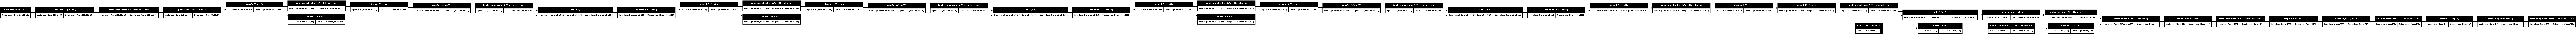

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming `model` is your Keras model instance
plot_model(embedding_model, to_file='model_horizontal.png', show_shapes=True, show_layer_names=True, rankdir='LR')


In [2]:
save_dir = '/content/drive/MyDrive/Contrastive Learning/preprocessed_data'
# Load preprocessed images and labels
images = np.load(os.path.join(save_dir, 'images.npy'))
labels = np.load(os.path.join(save_dir, 'labels.npy'))

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Data loaded and split into training and validation sets.")

Data loaded and split into training and validation sets.


In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_super_complex_model(input_shape=(224, 224, 3)):
    # Load the EfficientNetB7 model pre-trained on ImageNet
    base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the base model's layers to retain the pretrained features
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer for regression
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the super complex model
model = build_super_complex_model()

# Compile the model with MSE loss and a very low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mean_squared_error',
              metrics=['mae'])

model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Modelling/best_complex_model.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min')

callbacks = [early_stopping, model_checkpoint]

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the generator to augment images during training
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)

# Correctly calculate the steps per epoch
steps_per_epoch = len(X_train) // 16  # Ensure this is correct

# Train the model using the augmented data generator
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # Ensure this is correct
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=callbacks
)

# Save the final model after training
model.save('/content/drive/MyDrive/Modelling/final_complex_model.keras')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 67,383,704 (257.05 MB)

 Trainable params: 3,282,433 (12.52 MB)

 Non-trainable params: 64,101,271 (244.53 MB)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - loss: 28.6717 - mae: 1.7410 - val_loss: 19.5171 - val_mae: 0.5304
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 22.4633 - mae: 1.5671 - val_loss: 19.5492 - val_mae: 0.4352
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 787ms/step - loss: 22.3891 - mae: 1.4201 - val_loss: 18.9104 - val_mae: 0.6998
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 635ms/step - loss: 19.5256 - mae: 1.0929 - val_loss: 18.8864 - val_mae: 0.7032
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 777ms/step - loss: 20.1033 - mae: 1.1702 - val_loss: 17.1628 - val_mae: 0.4988
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 670ms/step - loss: 19.0608 - mae: 1.3196 - val_loss: 17.1411 - val_mae: 0.4892
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 915ms/step - loss: 19.2986 - mae: 1.2319 - val_loss: 16.0317 - val_mae: 0.7036
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 738ms/step - loss: 15.6253 - mae: 0.5622 - val_loss: 15.9926 - val_mae: 0.6882
Epoch 9/100
43/43 ━━━━━━━━━━